# Step 2: Controlled Generation of Small Molecules with `MolMIM` and QED

### RORc Nuclear Receptor Antagonist Case-Study
Rene, O.; *et al*. "[Minor Structural Change to Tertiary Sulfonamide RORc Ligands Led to Opposite Mechanisms of Action.](https://pubs.acs.org/doi/10.1021/ml500420y)" *ACS Med. Chem. Lett.* **2015**, *6*, 276-281.

This tutorial demonstrates how to generate small molecules with [MolMIM](https://arxiv.org/abs/2208.09016). The `MolMIM` model generates small molecules while optimizing properties of interest with the [Covariance matrix adaptation evolution strategy (CMA-ES)](https://en.wikipedia.org/wiki/CMA-ES) algorithm. The basic steps in one iteration of the optimization are:

1. Decode latent representations into SMILES strings.
2. Score generated SMILES strings based on the oracle function.
3. Update the CMA-ES algorithm with the SMILES/score pairing.
4. Ask the CMA-ES algorithm for a new set of latent space representations to sample.

An API call to the [NVIDIA MolMIM NIM](https://docs.nvidia.com/nim/bionemo/molmim/latest/overview.html) will handle all of the above steps.

## 2.1 Set Up the Environment

In [1]:
!pip install rdkit python-dotenv pandas numpy matplotlib loguru py3dmol

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.6 MB/s eta 0:00:00


In [2]:
import pickle
from typing import List
import numpy as np
import ast
import os, shutil, requests
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from rdkit import Chem
from rdkit.Chem.QED import qed
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from google.colab import userdata

## 2.2 Define the `SEED` Molecule

Using the `SEED` from [PDB: 4WQP](https://www.rcsb.org/structure/4WQP), which is **Compd 2** in Rene, O.; *et al*. "[Minor Structural Change to Tertiary Sulfonamide RORc Ligands Led to Opposite Mechanisms of Action.](https://pubs.acs.org/doi/10.1021/ml500420y)" *ACS Med. Chem. Lett.* **2015**, *6*, 276-281.

**Compd 2** was an antagonist with a RORc SRC1 EC<SUB>50</SUB> = 57 nM (-96% efficacy)

Original QED: 0.6278471478574387


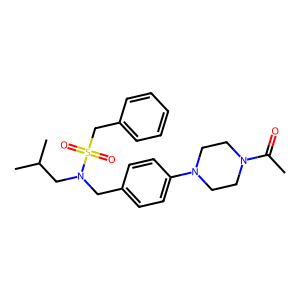

In [3]:
smis = "CC(C)CN(Cc1ccc(cc1)N2CCN(CC2)C(C)=O)[S](=O)(=O)Cc3ccccc3"

mol = Chem.MolFromSmiles(smis)
qed_score = qed(mol)
print(f"Original QED: {qed_score}")

# Generate an image from the molecule
img = Draw.MolToImage(mol, size=(300, 300))
display(img)  # hTis will display the SM image in a Jupyter Notebook

## 2.3 Guided Small Molecule Generation with CMA-ES

Unlike random sampling of the latent space (available when self-hosting NVIDIA `MolMIM` NIM — see [doc](https://docs.nvidia.com/nim/bionemo/molmim/latest/endpoints.html#)), we use a black-box optimizer called CMA-ES to guide small molecule generation. In the cells below, CMA-ES is used to optimize the [QED score](https://www.nature.com/articles/nchem.1243) of generated molecules while maintaining similarity to the `SEED` molecule in [PDB: 4WQP](https://www.rcsb.org/structure/4WQP).

For demonstration purposes, we’ll generate molecules using a range of minimum similarity thresholds — from 0.6 to 0.9 — at three evenly spaced intervals.

In [15]:
# Create a dictionary to store the results
results = {}

# Create a list of minimum similarities
num_min_sims = 3
min_sims = np.linspace(0.6, 0.9, num_min_sims)

In [16]:
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.DataStructs import TanimotoSimilarity


def tanimoto_similarity(smiles, reference: str):
    # Get fingerprint params
    generator = GetMorganGenerator(radius=2, fpSize=2048)

    # Handle the reference molecule
    reference_mol = Chem.MolFromSmiles(reference)
    reference_fingerprint = generator.GetFingerprint(reference_mol)

    # Validate the other molecule
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0

    fingerprint = generator.GetFingerprint(mol)

    # Calculate and return the Tanimoto similarity
    return TanimotoSimilarity(fingerprint, reference_fingerprint)

### Set up the `MolMIM` NIM URL and `API_KEY`

NOTE: Be sure to follow the steps in the [README](https://github.com/bf-nv/bionemo_tutorials/blob/main/README.md) to embed your NVIDIA `API_KEY` into your Google Colab environment.

In [17]:
API_KEY = userdata.get('API_KEY')
# print(API_KEY)

headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Accept": "application/json",
}

invoke_url = "https://health.api.nvidia.com/v1/biology/nvidia/molmim/generate"

session = requests.Session()

### Query `MolMIM` and aggregate the ligand metrics

The block below contains the main loop. It iterates over each minimum similarity value in the `min_sims` list, generating molecules using the CMA-ES algorithm. For each set, it cleans the generated molecules, calculates their Tanimoto similarity and QED scores, and stores the results in a dictionary called `results`. Each key in this dictionary corresponds to a minimum similarity value, and each value contains the valid SMILES strings, their count, average Tanimoto similarity, and average QED score.

In [18]:
num_molecules = 10

gen_smiles = []
gen_qed = []
gen_tanimoto = []

# Loop through each minimum similarity value
for min_sim in min_sims:
    # Create a dictionary to store the results for this min_sim
    min_sim_results = {'smiles': [], 'num_smiles': [], 'tanimoto_similarity': [], 'qed_score': []}

    # Create the request payload
    payload = {
      "smi": smis,
      "algorithm": "CMA-ES",
      "num_molecules": num_molecules,
      "property_name": "QED",
      "minimize": False,
      "min_similarity": min_sim,
      "particles": 20,
      "iterations": 2,
    }

    # Send the request and get the response
    response = session.post(invoke_url, headers=headers, json=payload)
    response.raise_for_status()
    response_json = response.json()
    print(f"*************** min_sim: {min_sim} ********************")
    print(f"response_json: \n"
          f"{response_json}")

    # Extract the generated SMILES
    gen_smiles_list = [i['sample'] for i in ast.literal_eval(response_json['molecules'])]
    print(f"gen_smiles_list: \n"
          f"{gen_smiles_list}")
    # Get the molecule objects out of valid SMILES
    valid_mol_list = [mol for smiles in gen_smiles_list if (mol := Chem.MolFromSmiles(smiles))]
    # Convert to canonical SMILES & deduplicate
    canonical_smiles = set()
    for mol in valid_mol_list:
        canonical_smi = Chem.MolToSmiles(mol, canonical=True)
        canonical_smiles.add(canonical_smi)
    canonical_smiles_list = list(canonical_smiles)
    gen_smiles.extend(canonical_smiles_list)
    print(f"canonical_smiles_list: \n"
          f"{canonical_smiles_list}")

    # Calculate Tanimoto similarity and QED score for each valid SMILES
    for smiles in canonical_smiles_list:
        tanimoto = tanimoto_similarity(smiles, smis)
        mol = Chem.MolFromSmiles(smiles)
        qed_score = qed(mol)
        min_sim_results['tanimoto_similarity'].append(tanimoto)
        min_sim_results['qed_score'].append(qed_score)
    gen_tanimoto.extend(min_sim_results['tanimoto_similarity'])
    gen_qed.extend(min_sim_results['qed_score'])

    # Update min_sim_results - get the average of Tanimoto and QED scores, store generated SMILES
    min_sim_results_mean = {}
    min_sim_results_mean['tanimoto_similarity'] = np.mean(min_sim_results['tanimoto_similarity'])
    min_sim_results_mean['qed_score'] = np.mean(min_sim_results['qed_score'])
    min_sim_results_mean['num_smiles'] = len(canonical_smiles_list)
    min_sim_results_mean['smiles'] = canonical_smiles_list

    # Store the results for this min_sim
    results[min_sim] = min_sim_results_mean

*************** min_sim: 0.6 ********************
response_json: 
{'molecules': '[{"sample": "CC(C)Cn1c(=O)c2ccccc2c(=O)n(CCCN(C)C)c1=O", "score": 0.7959302968512375}, {"sample": "CC(C)CN(CCC#N)S(=O)(=O)c1cc(C(F)(F)F)ccc1C(=O)O", "score": 0.7864756821963459}, {"sample": "CC(C)c1cccc(CN(Cc2ccc3c(c2)C(=O)NCC3)C2CCN(C)CC2)c1", "score": 0.7826501292041864}, {"sample": "CC(C)CN(CCC(F)(F)F)C(=O)CN(C)C(=O)c1ccccc1", "score": 0.7621146343651025}, {"sample": "CC(C)CN(Cc1ccc(C(N)=O)cc1)C(=O)C(=O)N(C)Cc1cccs1", "score": 0.7410273805923202}, {"sample": "CC(C)CN(Cc1ccccc1)C(=O)CN1C(=O)CN(C(C)C)C1=O", "score": 0.712811662729939}, {"sample": "CN1CCN(CC(=O)N[C@@H](Cc2ccccc2)C(=O)OCc2ccccc2)CC1", "score": 0.6897456813431346}, {"sample": "CC(C)CN(CCN1C(=O)NC2(CCCC2)C1=O)CC(=O)O", "score": 0.681666688383771}, {"sample": "CC(=O)c1ccc(Cn2c(=O)c3ccccc3n(CC(C)C)c2=O)cc1", "score": 0.6645427209966916}, {"sample": "CC(C)CN(CCN(C)C)C(=O)[C@@H](Cc1ccccc1)N1C(=O)c2ccccc2C1=O", "score": 0.5843492685422568}]', 'sco

After the loop concludes, the results are converted into a Pandas dataframe for further analysis.

In [19]:
keys_to_include = ['num_smiles', 'tanimoto_similarity', 'qed_score']
# Create the DataFrame, selecting only the specified keys from each inner dictionary
df = pd.DataFrame({k: {key: val[key] for key in keys_to_include} for k, val in results.items()}).T.reset_index()
print(df)

   index  num_smiles  tanimoto_similarity  qed_score
0   0.60        10.0             0.246253   0.720131
1   0.75        10.0             0.236194   0.761077
2   0.90        10.0             0.263406   0.722968


### Visualize the ligand metrics

The block below generates three plots to visualize the results:

1) The number of valid SMILES strings,
2) The average Tanimoto similarity, and
3) The average QED score at each minimum similarity threshold.

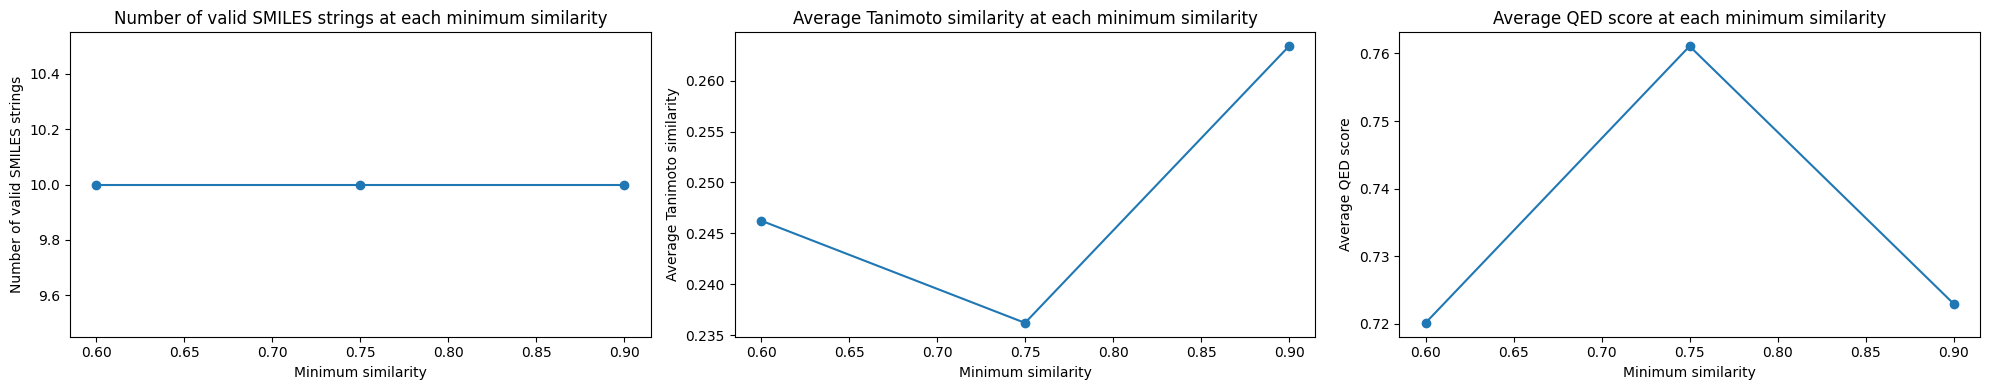

In [20]:
# Create the plots
plt.figure(figsize=(20, 4))

# Plot the number of valid SMILES strings at each min_sim
plt.subplot(1, 3, 1)
plt.plot(df['index'], df['num_smiles'], linestyle='-', marker='o')
plt.xlabel('Minimum similarity')
plt.ylabel('Number of valid SMILES strings')
plt.title('Number of valid SMILES strings at each minimum similarity')

# Plot the average Tanimoto similarity at each radius
plt.subplot(1, 3, 2)
plt.plot(df['index'], df['tanimoto_similarity'], linestyle='-', marker='o')
plt.xlabel('Minimum similarity')
plt.ylabel('Average Tanimoto similarity')
plt.title('Average Tanimoto similarity at each minimum similarity')

# Plot the average QED score at each radius
plt.subplot(1, 3, 3)
plt.plot(df['index'], df['qed_score'], linestyle='-', marker='o')
plt.xlabel('Minimum similarity')
plt.ylabel('Average QED score')
plt.title('Average QED score at each minimum similarity')

plt.tight_layout()
plt.show()

### Visulaize the generated ligands

In [21]:
num_smiles = df['num_smiles'].tolist()
gen_minsims = [float(min_sim) for min_sim, num_ in zip(min_sims, num_smiles) for _ in range(int(num_))]

gen_tanimoto = [round(_, 2) for _ in gen_tanimoto]
gen_qed = [round(_, 2) for _ in gen_qed]

df_viz = pd.DataFrame({
    'smiles': gen_smiles,
    'minsim': gen_minsims,
    'tanimoto': gen_tanimoto,
    'qed': gen_qed
})
df_viz = df_viz.sort_values(
    by=['tanimoto', 'minsim', 'qed'],
    ascending=[False, False, False])
df_viz.head()

,smiles,minsim,tanimoto,qed
21,CC(C)CN(CC(=O)N1CCCC1)C(=O)Cc1ccccc1,0.90,0.38,0.81
26,CC(C)CN(Cc1ccccc1)Cc1ccccc1N1CCN(C)CC1,0.90,0.38,0.74
24,CC(C)N(CC(=O)N(Cc1ccccc1)C1CCN(C(=O)NC2CC2)CC1...,0.90,0.33,0.61
0,CC(C)CN(Cc1ccccc1)C(=O)CN1C(=O)CN(C(C)C)C1=O,0.60,0.33,0.71
19,CC(C)N(Cc1ccccc1)C(=O)CN(Cc1ccc(F)cc1)C[C@]1(O...,0.75,0.32,0.65


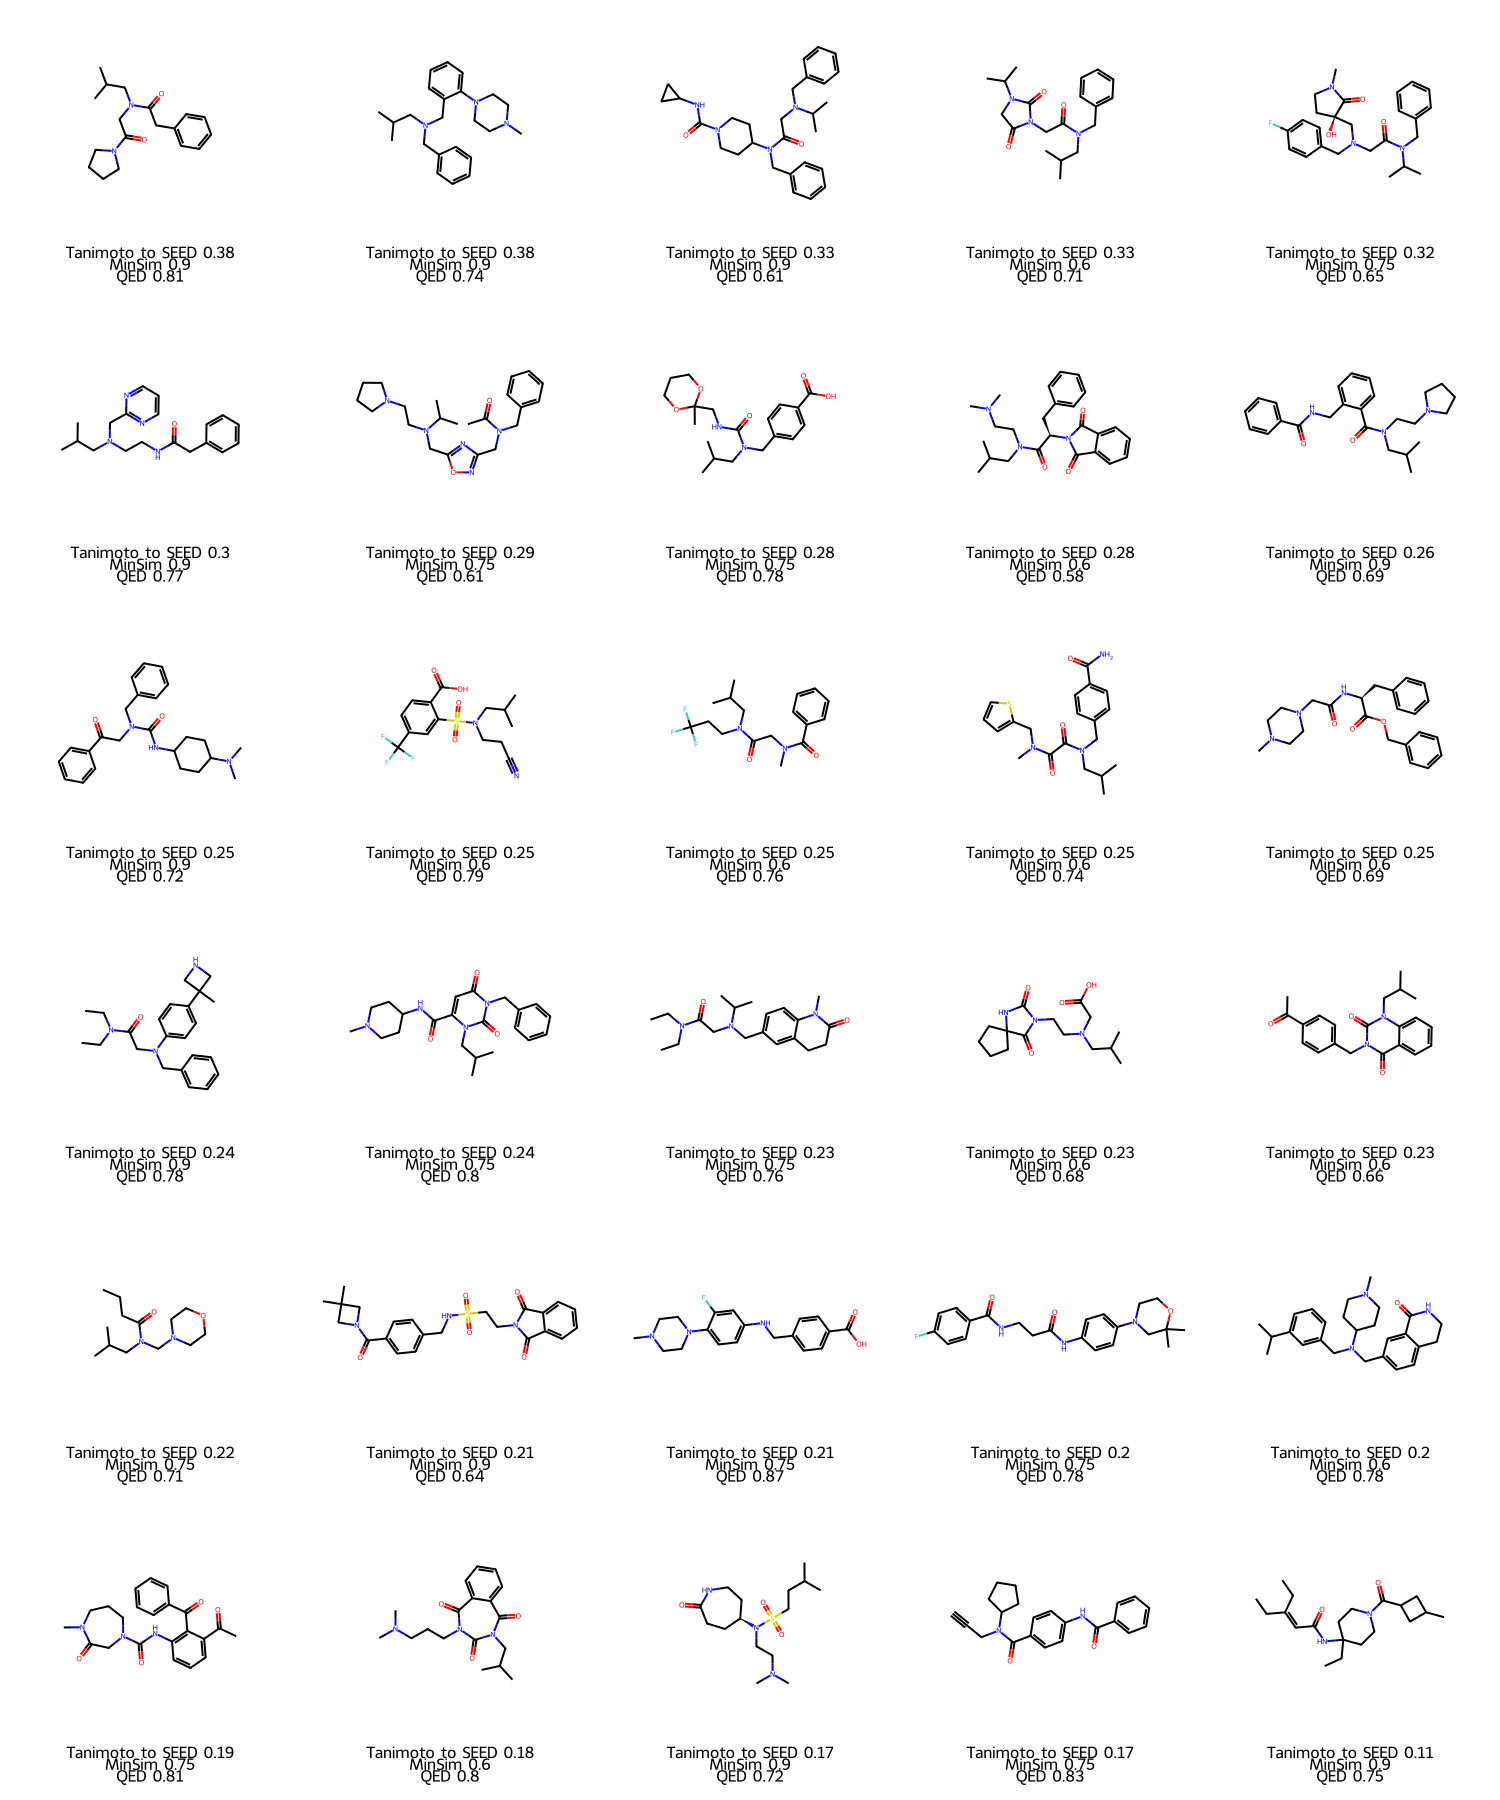

In [23]:
df_smiles = df_viz["smiles"].tolist()
df_minsim = df_viz["minsim"].tolist()
df_tanimoto = df_viz["tanimoto"].tolist()
df_qed = df_viz["qed"].tolist()
ms = [Chem.MolFromSmiles(_) for _ in df_smiles]
dopts = Draw.MolDrawOptions()
dopts.legendFontSize=16
dopts.legendFraction=0.2
Draw.MolsToGridImage(ms,
                     molsPerRow=5,
                     subImgSize=(300, 300),
                     legends = [f"Tanimoto to SEED {tanimoto}\nMinSim {min_sim}\nQED {qed}" for tanimoto, min_sim, qed in zip(df_tanimoto, df_minsim, df_qed)],
                     drawOptions=dopts,
                     )

## 2.4 Preprocess the Generated Small Molecules for use in `DiffDock`

In [ ]:
# choose the first N molecules from the individual runs to use for docking,
# for demo purpose we will set it to 5 for now.
N_molecules_for_docking = 5

# choose the first N molecules
# list is prioritized by highest Tanimoto similarity, highest MinSim, highest QED
molecules = df_smiles[:N_molecules_for_docking]

print(molecules)

['CC(=O)N1CCN(c2ccc(CN(CCN(C)C)C(=O)Cc3ccccc3)cn2)CC1', 'CC(C)CN(Cc1ccccc1)C(=O)CN1CC(=O)NC(C)(C)C1=O', 'CC(=O)NCC(=O)N(Cc1ccccc1)CN1CCC2(CCC2)C1', 'CC(C)Cc1ccc(C(=O)N2CC(=O)NC3(CCN(Cc4ccccc4)CC3)C2)cc1', 'CC(C)CN(CCNC(=O)c1ccccc1)C(=O)CN1CCC(C)C1']


In [ ]:
def prepare_output_directory(output):
    """
    Prepare the output directory
    output: str, the output directory
    return: None
    """
    # overwrite the output directory
    if os.path.exists(output):
        shutil.rmtree(output)
    os.makedirs(output)

Convert SMILES to SDF (generate 1 conformer for each SMILES)

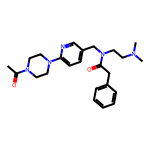

Converted SMILES to SDF: CC(=O)N1CCN(c2ccc(CN(CCN(C)C)C(=O)Cc3ccccc3)cn2)CC1


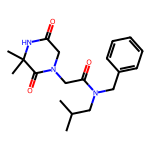

Converted SMILES to SDF: CC(C)CN(Cc1ccccc1)C(=O)CN1CC(=O)NC(C)(C)C1=O


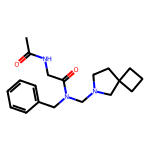

Converted SMILES to SDF: CC(=O)NCC(=O)N(Cc1ccccc1)CN1CCC2(CCC2)C1


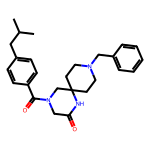

Converted SMILES to SDF: CC(C)Cc1ccc(C(=O)N2CC(=O)NC3(CCN(Cc4ccccc4)CC3)C2)cc1


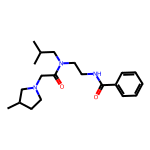

Converted SMILES to SDF: CC(C)CN(CCNC(=O)c1ccccc1)C(=O)CN1CCC(C)C1
['/content/output/molmim_result/clean_mols/molecule_0.sdf', '/content/output/molmim_result/clean_mols/molecule_1.sdf', '/content/output/molmim_result/clean_mols/molecule_2.sdf', '/content/output/molmim_result/clean_mols/molecule_3.sdf', '/content/output/molmim_result/clean_mols/molecule_4.sdf']


In [ ]:
output_dir = "/content/output/molmim_result"
output_dir_clean = os.path.join(output_dir, "clean_mols")
prepare_output_directory(output_dir_clean)

# convert to SDF
output_sdf_files = []
for i, smiles in enumerate(molecules):
    mol_2d = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol_2d)
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)
    img = Draw.MolToImage(mol_2d, size=(150, 150))
    display(img)

    # save the clean file
    path = f"{output_dir_clean}/molecule_{i}.sdf"
    w = Chem.SDWriter(path)
    w.write(mol)
    w.close()
    print(f"Converted SMILES to SDF: {smiles}")
    output_sdf_files.append(path)

# here are the paths to the generated molecules in SDF format, which can be used for docking
print(output_sdf_files)

### Download SDF files which need to be uploaded in Step 3 - Using DiffDock to Predict Docking Poses

In [ ]:
# Step 1: Zip the directory
zip_filename = "clean_mols.zip"
!cd {output_dir_clean} && zip -r {zip_filename} .

  adding: molecule_4.sdf (deflated 79%)
  adding: molecule_0.sdf (deflated 79%)
  adding: molecule_3.sdf (deflated 79%)
  adding: molecule_2.sdf (deflated 79%)
  adding: molecule_1.sdf (deflated 79%)


In [ ]:
# Step 2: Download the zipped file
from google.colab import files
files.download(os.path.join(output_dir_clean, zip_filename))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>